In [77]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets
import pickle

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/nullspace/")

%matplotlib inline

- We have computed solutions in EMG space
- If we subtract out the "pseudoinverse" solution, this will give us an idea of the error in task space, leaving the null space activity
- Then lets look at the projections of this error into the task and null space to see how much is where, and when!


"If Y has a lognormal distribution with parameters \mu and \sigma, then cY has a lognormal distribution with parameters \mu+\log(c) and \sigma."

Our decoder is normally distributed -- we could approximate the output of this projection somehow, but it will not be lognormal as it's no longer positive

We'll look at the EMG space errors in their original space, as log transforming and subsequently projecting will lead to a misrepresentation of the data



## load data

In [78]:
with open('../olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [79]:
# with open("../../computed_solutions.pkl","rb") as handle:
#     computed_solutions = pickle.load(handle)

# # 0 the "pinv" solution
# # 1 movement mean error
# # 2 calibration mean error
# # 3 the "gaussian" likelihood with movement stats solution
# # 4 the "gaussian" likelihood with calibration stats
# # 5 the movement mixture likelihood solution nonnegative -- starting from gaussian solution
# # 6 the calibration mixture likelihood solution nonnegative -- starting from gaussian solution

# solution_type = 0

# # all computed per-subject solutions of this type
# solutions = computed_solutions[:,solution_type]
# solutions.shape

In [80]:
# solutions = np.zeros_like(solutions)

In [81]:
# subject_idx = 26
# subject_solutions = solutions[subject_idx]
# subject_solutions.shape

## load and inspect trial data for one subject by target

In [82]:
subject_idx = 26
subject_trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")
print(subject_trial_stack.shape)

(45, 12, 64, 2000)


/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/data_fix/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


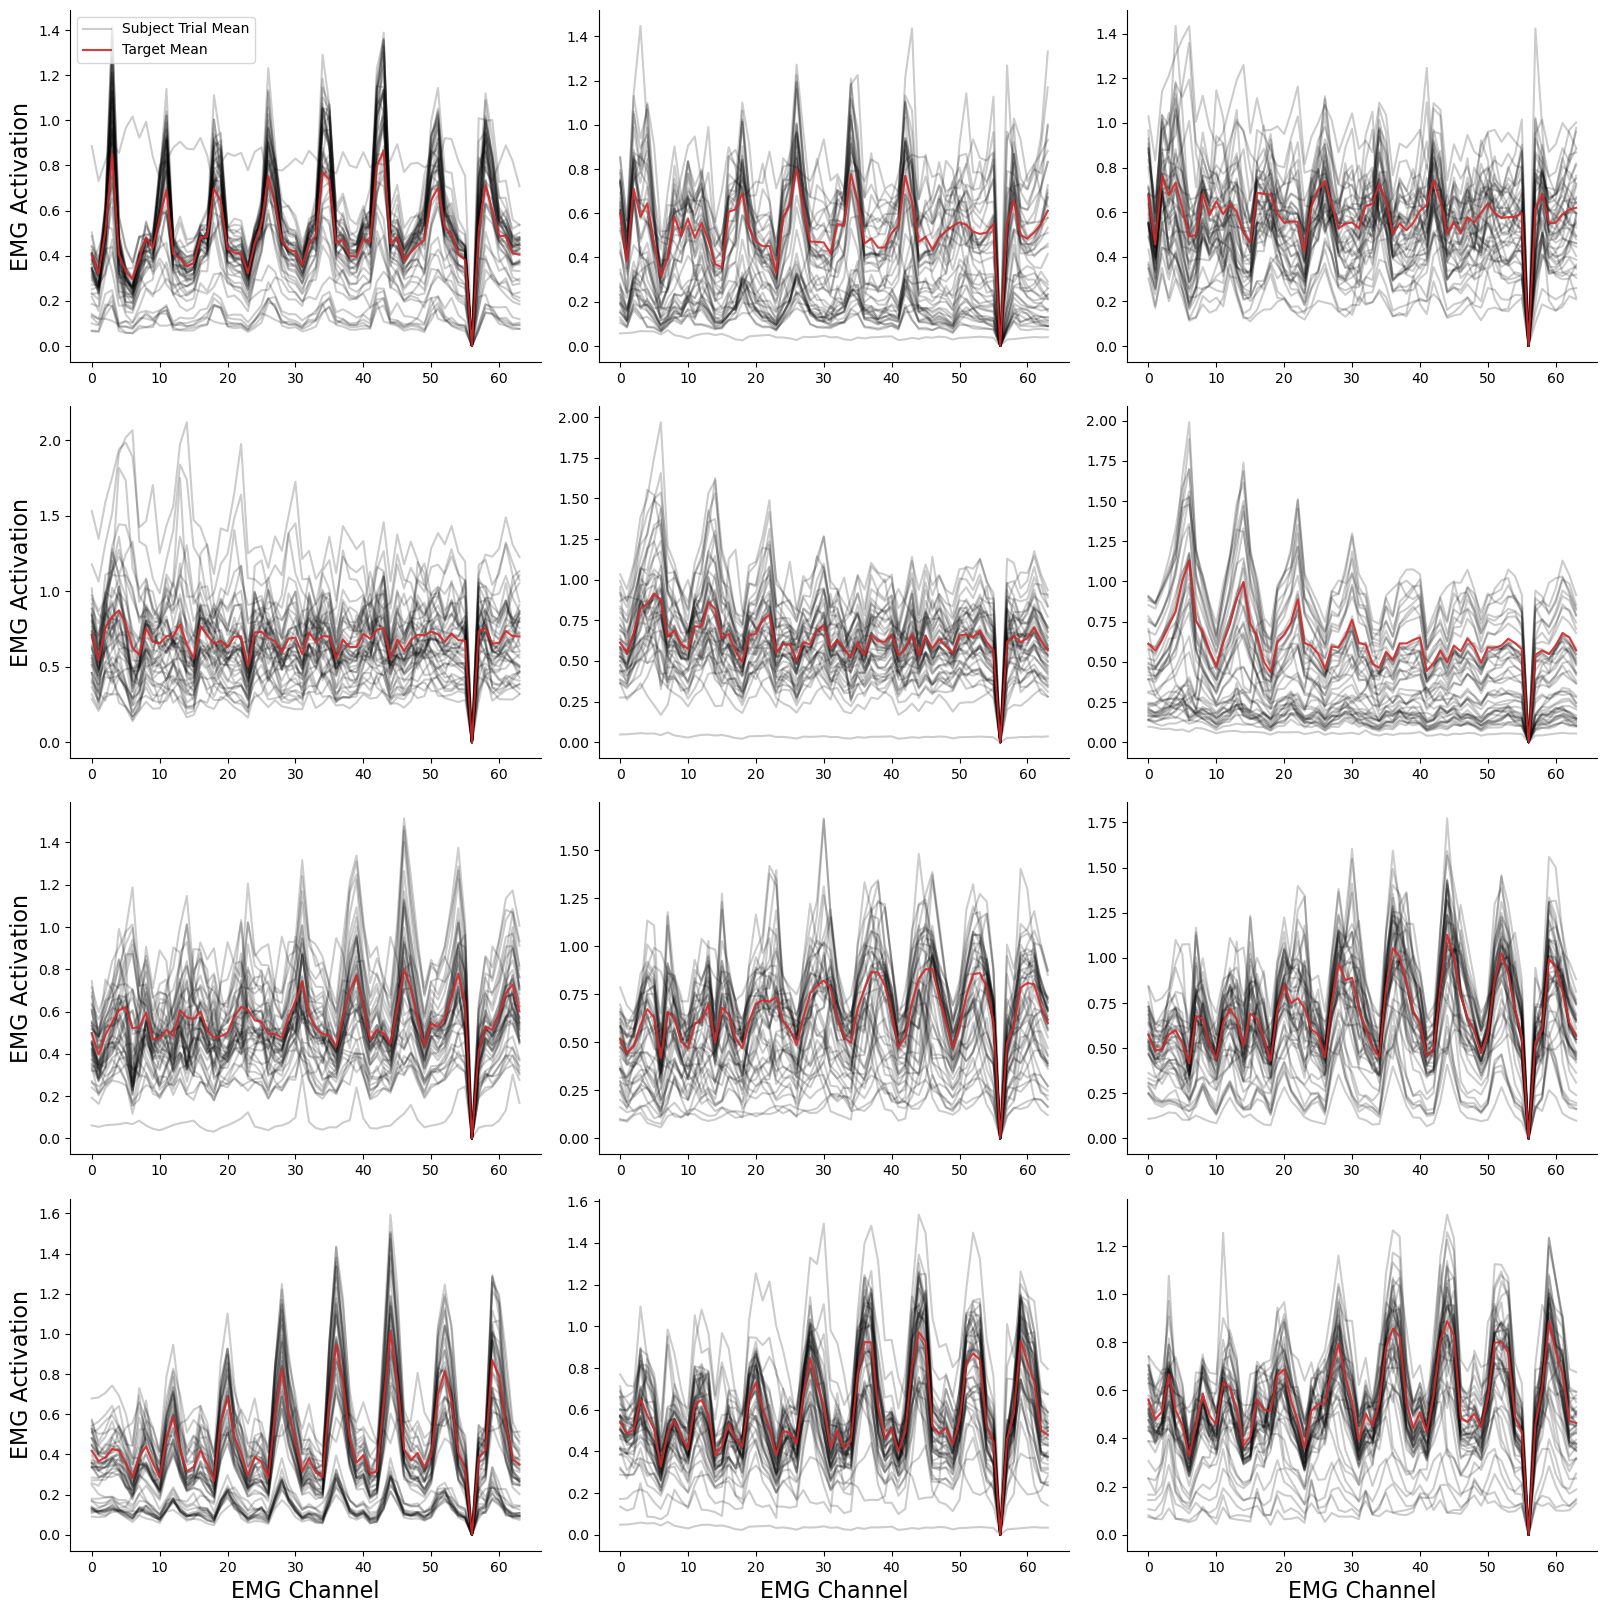

In [83]:
# subject_differences = np.zeros_like(subject_trial_stack)
# subject_differences[:] = np.nan
# for block_idx, block in enumerate(subject_trial_stack):
#     for target_idx, target in enumerate(block):
#         no_nans = analysis.remove_nan_rows(target.T)
#         for sample_idx, sample in enumerate(no_nans):
#             subject_differences[block_idx,target_idx,:,sample_idx] = sample.reshape(-1) - subject_solutions[target_idx].reshape(-1)

fig, axes = plt.subplots(4,3,figsize=(16,16))
fig.tight_layout()
axes = axes.ravel()
ylabel = [0,3,6,9]
xlabel = [9,10,11]
for block in subject_trial_stack:
    for target_idx, target in enumerate(block):
        no_nans = analysis.remove_nan_rows(target.T)
        # just plot the means over time
        h1, = axes[target_idx].plot(np.mean(no_nans,axis=0),"k",linestyle="-",marker="",alpha=0.2)
        if target_idx in ylabel:
            axes[target_idx].set_ylabel("EMG Activation")
        if target_idx in xlabel:
            axes[target_idx].set_xlabel("EMG Channel")

for target_idx in range(12):
    h2, = axes[target_idx].plot(np.nanmean(subject_trial_stack[:,target_idx],axis=(0,2)),"tab:red",linestyle="-",marker="",alpha=0.9)        
    # h2, = axes[target_idx].plot(subject_solutions[target_idx],"tab:red",linestyle="-",marker="")
axes[0].legend(handles=[h1,h2],labels=["Subject Trial Mean", "Target Mean"])
# fig.suptitle("Mean Trial Error and Optimal Solutions",fontsize=16)


In [84]:
plot.save_figure(fig, "example_samples", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/example_samples.pdf


# all subjects

### for 5 chunks, look at the null and task space projections of the error

In [85]:
calibration_stacks = np.load("../subject_filtered_calibration_stacks.npy")
movement_stacks = np.load("../subject_filtered_movement_stacks.npy")
calibration_stacks.shape, movement_stacks.shape

((46, 2, 32, 64, 2400), (46, 2, 14, 64, 2000))

### test spherical gaussian as a null hypothesis

In [86]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
subject_ratios = []

for subject_idx in range(46):
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    target_ratios = []
    for target_idx in range(12):
        chunk_ratios = []
        for idxs in chunk_indices:
            chunk_ratios += [(analysis.mean_quadratic_form(np.eye(64),subspace_basis=task) / analysis.mean_quadratic_form(np.eye(64),subspace_basis=null)).reshape(-1)]
        target_ratios += [chunk_ratios]

    subject_ratios += [target_ratios]

subject_ratios = np.array(subject_ratios)[:,:,:,0]
subject_ratios.shape

(46, 12, 5)

(0.0, 2.0)

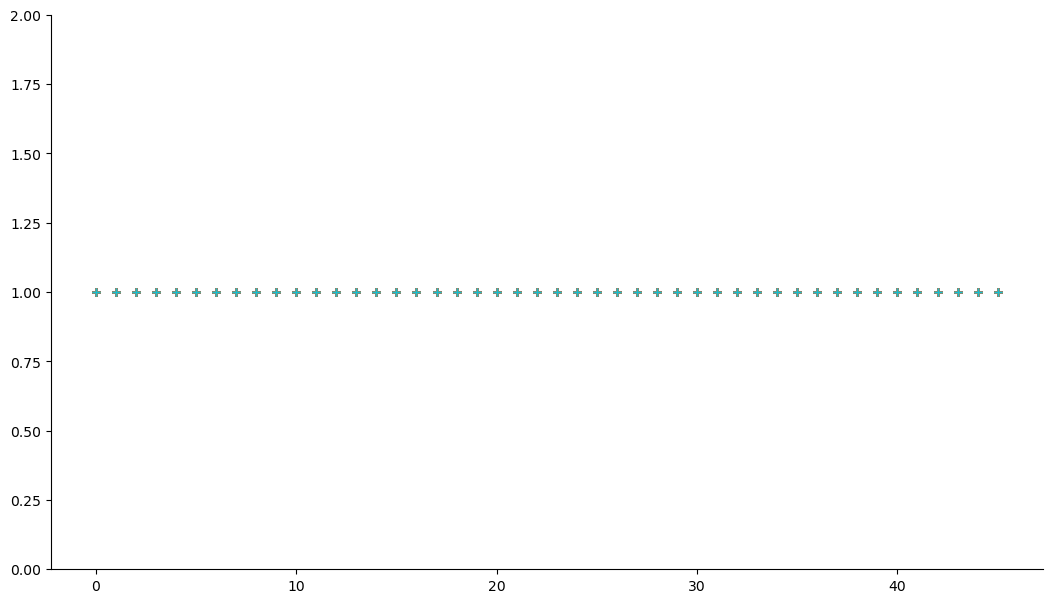

In [87]:
for j in range(5):
    for i in range(12):
        plt.plot(subject_ratios[:,i,j])

plt.ylim([0,2])

In [88]:
chunk_indices = list(zip(np.arange(0,45,9),np.arange(9,46,9)))
# chunk_indices = list(zip(np.arange(0,45,5),np.arange(5,46,5)))

# compute differences
subject_ratios = []
for subject_idx in range(46):
    subject_trial_stack = np.load(f"../filtered_stacks/filtered_stack_{subject_idx}.npy")
    # subject_differences = np.zeros_like(subject_trial_stack)
    # subject_differences[:] = np.nan
    # # for every sample, subtract the computed solution
    # for block_idx, block in enumerate(subject_trial_stack):
    #     for target_idx, target in enumerate(block):
    #         no_nans = analysis.remove_nan_rows(target.T)
    #         for sample_idx, sample in enumerate(no_nans):
    #             subject_differences[block_idx,target_idx,:,sample_idx] = sample.reshape(-1) - solutions[subject_idx,target_idx].reshape(-1)
    # compute ratios in chunks
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    target_ratios = []
    for target_idx in range(12):
        chunk_ratios = []
        for idxs in chunk_indices:
            samples = subject_trial_stack[:,target_idx]
            chunk_samples = analysis.remove_nan_rows(samples[idxs[0]:idxs[1]].transpose(0,2,1).reshape(-1,64))
            # we don't want to penalize people for being unable to activate channel 56, so we make the error here 0
            chunk_samples[:,56] = 0
            # covariances of each half
            chunk_ratios += [(analysis.mean_quadratic_form(np.cov(chunk_samples.T),subspace_basis=task) / analysis.mean_quadratic_form(np.cov(chunk_samples.T),subspace_basis=null)).reshape(-1)]
        target_ratios += [chunk_ratios]
    subject_ratios += [target_ratios]
subject_ratios = np.array(subject_ratios)[:,:,:,0]
subject_ratios.shape

(46, 12, 5)

In [89]:
subject_calibration_ratios = []
subject_movement_ratios = []
for subject_idx in range(46):
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    calibration_ratios = []
    movement_ratios = []
    for target_idx in range(12):
        calibration_samples = analysis.remove_nan_rows(calibration_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)) # - solutions[subject_idx,target_idx].reshape(-1)
        movement_samples = analysis.remove_nan_rows(movement_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)) # - solutions[subject_idx,target_idx].reshape(-1)
        calibration_ratios += [(analysis.mean_quadratic_form(np.cov(calibration_samples.T),subspace_basis=task) / analysis.mean_quadratic_form(np.cov(calibration_samples.T),subspace_basis=null)).reshape(-1)]
        movement_ratios += [(analysis.mean_quadratic_form(np.cov(movement_samples.T),subspace_basis=task) / analysis.mean_quadratic_form(np.cov(movement_samples.T),subspace_basis=null)).reshape(-1)]
    subject_calibration_ratios += [calibration_ratios]
    subject_movement_ratios += [movement_ratios]
subject_calibration_ratios = np.array(subject_calibration_ratios)[:,:,0]
subject_movement_ratios = np.array(subject_movement_ratios)[:,:,0]
subject_calibration_ratios.shape, subject_movement_ratios.shape

((46, 12), (46, 12))

## plot

In [90]:
ratio_stack = np.concatenate([subject_movement_ratios.mean(axis=1).reshape(-1,1),subject_calibration_ratios.mean(axis=1).reshape(-1,1),subject_ratios.mean(axis=1)],axis=1)
ratio_stack.shape

(46, 7)

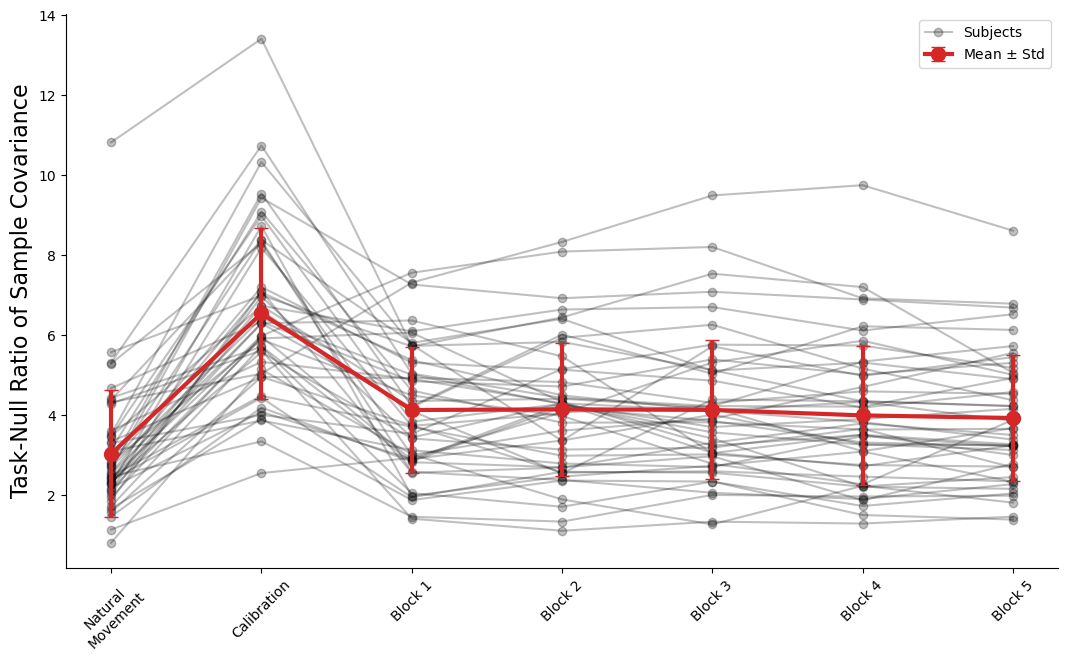

In [95]:
fig = plt.figure()
for i in range(46):
    h1, = plt.plot(range(7),ratio_stack[i,:],'ko-',alpha=0.25)
h2 = plt.errorbar(x=range(7),y=np.mean(ratio_stack,axis=(0)),yerr=np.std(ratio_stack,axis=(0)),color="tab:red",capsize=5,marker="o",linestyle="-",markersize=10,linewidth=3)
plt.xticks(range(7),["Natural\nMovement", "Calibration"] + [f"Block {i+1}" for i in range(5)],rotation=45)
plt.ylabel("Task-Null Ratio of Sample Covariance")
plt.legend(handles=[h1,h2],labels=["Subjects","Mean $\pm$ Std"])

In [96]:
plot.save_figure(fig, "sample_ratio",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/sample_ratio.pdf


## significance

Text(995.8377777777777, 0.5, '$p$ value')

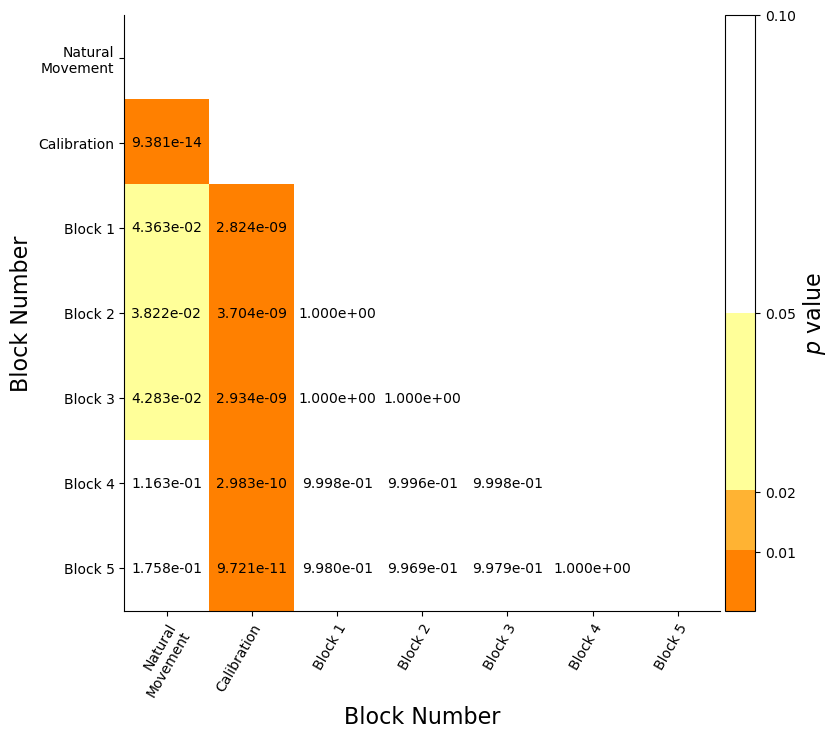

In [73]:
import scipy as sp

result = sp.stats.tukey_hsd(*ratio_stack.T)
ticklabels = ["Natural\nMovement", "Calibration"] + [f"Block {i+1}" for i in range(5)]
pvalue_fig, axes = plot.annotated_heatmap(result.pvalue,ticklabels,ticklabels)
axes[0].set_xlabel("Block Number")
axes[0].set_ylabel("Block Number")
axes[1].set_ylabel("$p$ value")

In [74]:
plot.save_figure(pvalue_fig, "sample_ratio_significance", image_path, format="png")

Figure saved to /Users/spencer/phd/phd/images/more_results/nullspace/sample_ratio_significance.png


So the task/null projection of the ERROR is greater than 1, which means that subject's errors, on average, lie more in the task plane compared to the null space. This implies that subjects, compared to their computed solutions, are making more task errors, diverging from this optimal solution in the task plane compared to the null space.

Most of the error will be in the task plane? The alternative here is to move a lot in the null space, differently every time, but still getting close to the target. This doesn't seem to be the case, people tend to be more variant in the task plane than the null space. But this is somewhat expected, because the task is defined by high-variance dimensions of subjects' natural repertoire.